        Train  Test  Val  Sum
A172      388   152   68  608
BT474     429   168   75  672
BV2       386   152   70  608
Huh7      352   200   65  617
MCF7      469   184   82  735
SHSY5Y    449   176   79  704
SKOV3     266   304   51  621
SkBr3     449   176   79  704


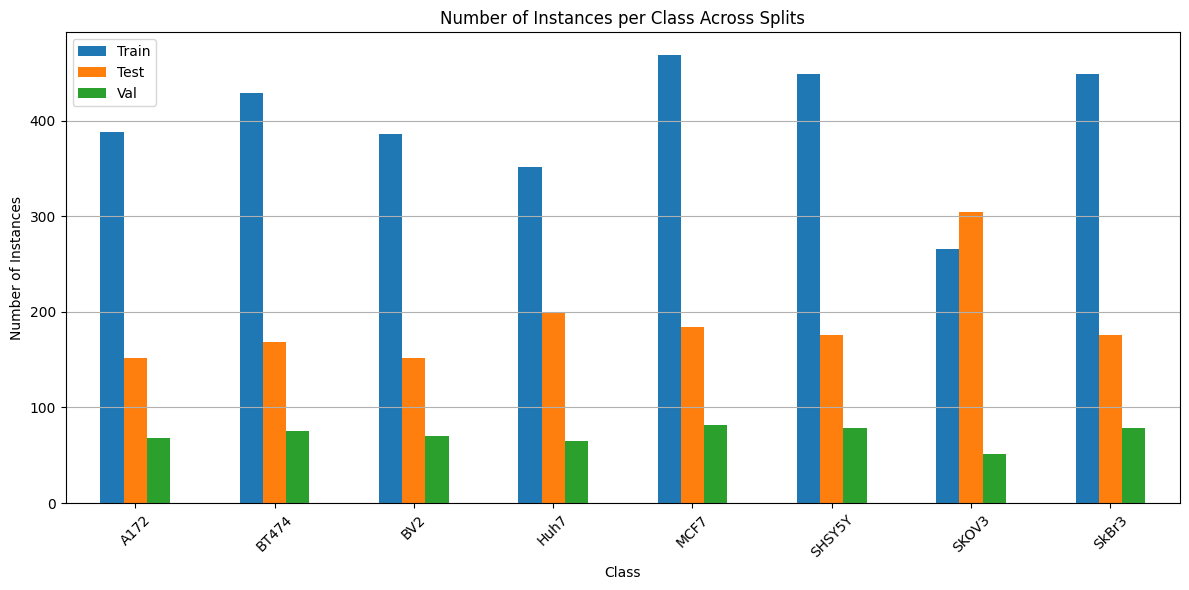

In [91]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from cfg import DATASET_DIR

train_dir = os.path.join(DATASET_DIR, 'train')
test_dir = os.path.join(DATASET_DIR, 'test')
val_dir = os.path.join(DATASET_DIR, 'val')

def get_file_names_and_classes(directory):
    files = os.listdir(directory)
    classes = [f.split('_')[0] for f in files]
    return set(classes), files

train_classes, train_files = get_file_names_and_classes(train_dir)
test_classes, test_files = get_file_names_and_classes(test_dir)
val_classes, val_files = get_file_names_and_classes(val_dir)

def count_classes(classes, files):
    return pd.Series([f.split('_')[0] for f in files]).value_counts()

train_class_counts = count_classes(train_classes, train_files)
test_class_counts = count_classes(test_classes, test_files)
val_class_counts = count_classes(val_classes, val_files)


class_counts_df = pd.DataFrame({
    'Train': train_class_counts,
    'Test': test_class_counts,
    'Val': val_class_counts
}).fillna(0) 
class_counts_df['Sum'] = class_counts_df['Train'] + class_counts_df['Test'] + class_counts_df['Val']
print(class_counts_df)
class_counts_df = class_counts_df.astype(int)

class_counts_df.drop(columns=['Sum']).plot(kind='bar', figsize=(12, 6))

plt.title('Number of Instances per Class Across Splits')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


According to the paper information I tend to think that this percentage of splits for SKOV3 specified in this way because of the cell importance and other cell-related factors. If the model is primarily trained on fewer SKOV3 samples, testing with more can reveal its strengths and weaknesses in recognizing this cell type.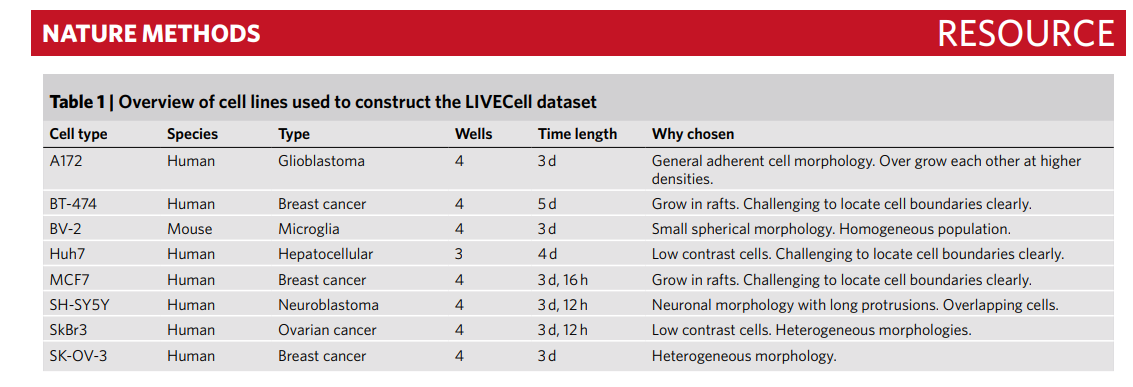

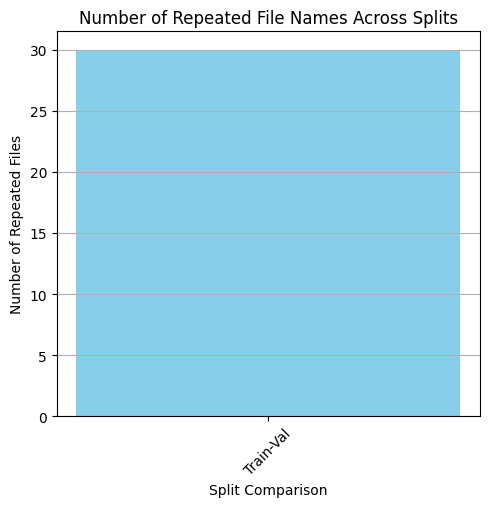

In [93]:
train_files_set = set(train_files)
test_files_set = set(test_files)
val_files_set = set(val_files)

train_test_overlap = train_files_set.intersection(test_files_set)
train_val_overlap = train_files_set.intersection(val_files_set)
test_val_overlap = test_files_set.intersection(val_files_set)

overlap_counts = {
    'Train-Test': len(train_test_overlap),
    'Train-Val': len(train_val_overlap),
    'Test-Val': len(test_val_overlap),
}
# Create DataFrame for overlap counts
counts_df = pd.DataFrame(overlap_counts.items(), columns=['Split', 'Count'])
counts_df = counts_df[counts_df['Count'] > 0]  # Filter out non-repeated counts

# Plotting repeated files between splits
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot
plt.bar(counts_df['Split'], counts_df['Count'], color='skyblue')
plt.title('Number of Repeated File Names Across Splits')
plt.xlabel('Split Comparison')
plt.ylabel('Number of Repeated Files')
plt.xticks(rotation=45)
plt.grid(axis='y')

   Split  Percentage
0  Train   60.851308
1   Test   28.860470
2    Val   10.860851


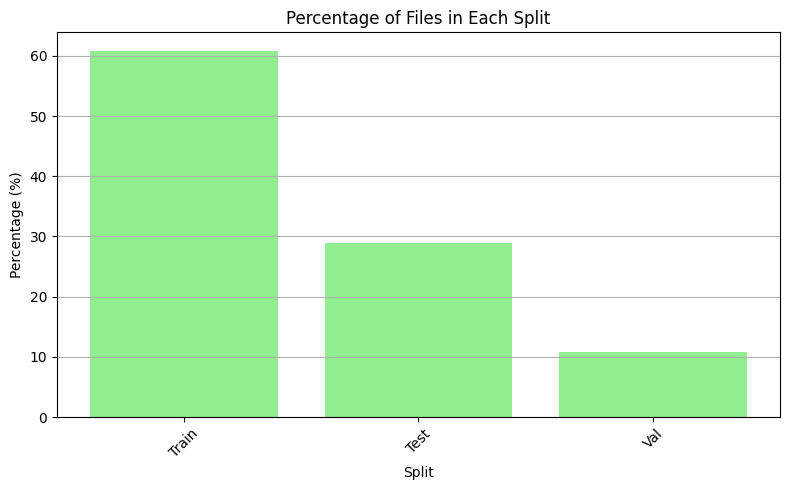

In [94]:
# Total number of unique files
total_files = len(train_files_set.union(test_files_set).union(val_files_set))

percentages = {
    'Train': len(train_files) / total_files * 100,
    'Test': len(test_files) / total_files * 100,
    'Val': len(val_files) / total_files * 100,
}

percentages_df = pd.DataFrame(percentages.items(), columns=['Split', 'Percentage'])
print(percentages_df)


plt.figure(figsize=(8, 5))
plt.bar(percentages_df['Split'], percentages_df['Percentage'], color='lightgreen')
plt.title('Percentage of Files in Each Split')
plt.xlabel('Split')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

The optimal split ratio depends on various factors. The rough standard for train-validation-test splits is 60-80% training data, 10-20% validation data, and 10-20% test data.

For a baseline will continue with this distribution. As an improvement we can try StratifiedShuffleSplit to balance classes in splits and change overal split percentage.

['Huh7', 'SKOV3']
Class-wise Overlap Counts:
       Train-Test  Train-Val  Test-Val
Huh7            0         17         0
SKOV3           0         13         0


C:\Users\user\AppData\Local\Temp\ipykernel_26776\236760378.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  overlap_df = pd.DataFrame(index=all_classes, columns=['Train-Test', 'Train-Val', 'Test-Val']).fillna(0)


<Figure size 1200x600 with 0 Axes>

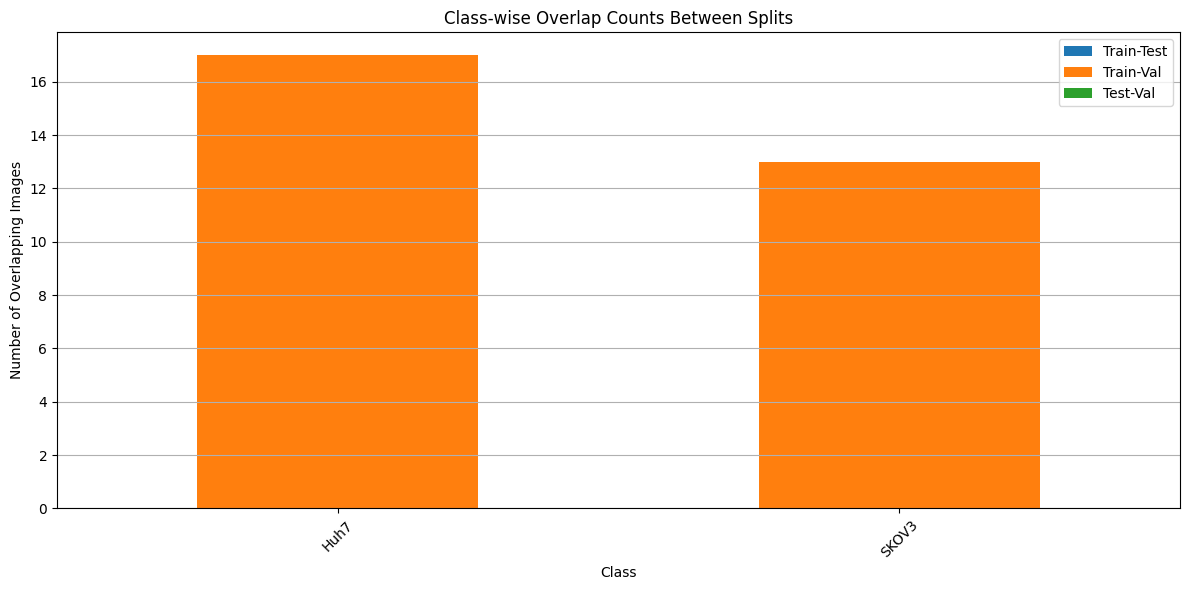

In [95]:
def get_overlap_info(files_a, files_b):
    overlap_files = files_a.intersection(files_b)
    overlap_counts = {}
    for file in overlap_files:
        class_label = file.split('_')[0]
        if class_label in overlap_counts:
            overlap_counts[class_label]+=1
        else:
            overlap_counts[class_label] = 1
    return overlap_files, overlap_counts
    
train_test_overlap_files, train_test_overlap_counts = get_overlap_info(train_files_set, test_files_set)
train_val_overlap_files, train_val_overlap_counts = get_overlap_info(train_files_set, val_files_set)
test_val_overlap_files, test_val_overlap_counts = get_overlap_info(test_files_set, val_files_set)

def prepare_overlap_df(train_test, train_val, test_val):
    all_classes = sorted(set(train_test.keys()).union(set(train_val.keys()), set(test_val.keys())))
    print(all_classes)
    overlap_df = pd.DataFrame(index=all_classes, columns=['Train-Test', 'Train-Val', 'Test-Val']).fillna(0)

    for cls in all_classes:
        overlap_df.at[cls, 'Train-Test'] = train_test.get(cls, 0)
        overlap_df.at[cls, 'Train-Val'] = train_val.get(cls, 0)
        overlap_df.at[cls, 'Test-Val'] = test_val.get(cls, 0)

    return overlap_df

overlap_df = prepare_overlap_df(train_test_overlap_counts, train_val_overlap_counts, test_val_overlap_counts)


print("Class-wise Overlap Counts:")
print(overlap_df)

plt.figure(figsize=(12, 6))
overlap_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Class-wise Overlap Counts Between Splits')
plt.xlabel('Class')
plt.ylabel('Number of Overlapping Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

This overlapping can create a validation leakage, so in order to fix it this this data will be removed form the training set and will be presented only in validation split. Amount is not significant in this case(30 images).

In [ ]:
for file in train_val_overlap_files:
    print(os.path.join(train_dir, file))
    os.remove(os.path.join(train_dir, file))
    print(f'Removed: {file} from {train_dir}')


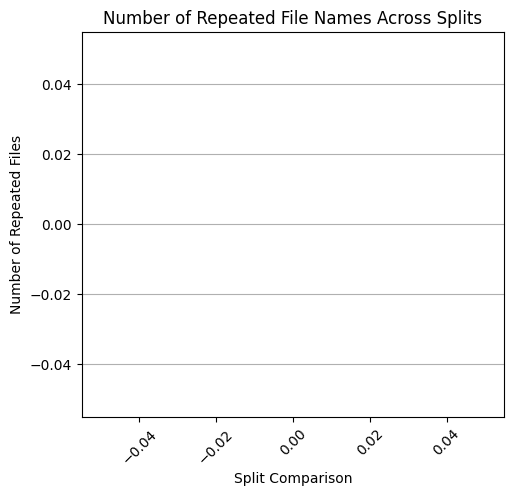

In [100]:
train_files_set = set(train_files)
test_files_set = set(test_files)
val_files_set = set(val_files)

train_test_overlap = train_files_set.intersection(test_files_set)
train_val_overlap = train_files_set.intersection(val_files_set)
test_val_overlap = test_files_set.intersection(val_files_set)

overlap_counts = {
    'Train-Test': len(train_test_overlap),
    'Train-Val': len(train_val_overlap),
    'Test-Val': len(test_val_overlap),
}
# Create DataFrame for overlap counts
counts_df = pd.DataFrame(overlap_counts.items(), columns=['Split', 'Count'])
counts_df = counts_df[counts_df['Count'] > 0]  # Filter out non-repeated counts

# Plotting repeated files between splits
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot
plt.bar(counts_df['Split'], counts_df['Count'], color='skyblue')
plt.title('Number of Repeated File Names Across Splits')
plt.xlabel('Split Comparison')
plt.ylabel('Number of Repeated Files')
plt.xticks(rotation=45)
plt.grid(axis='y')

Overlapped data is successfully removed.

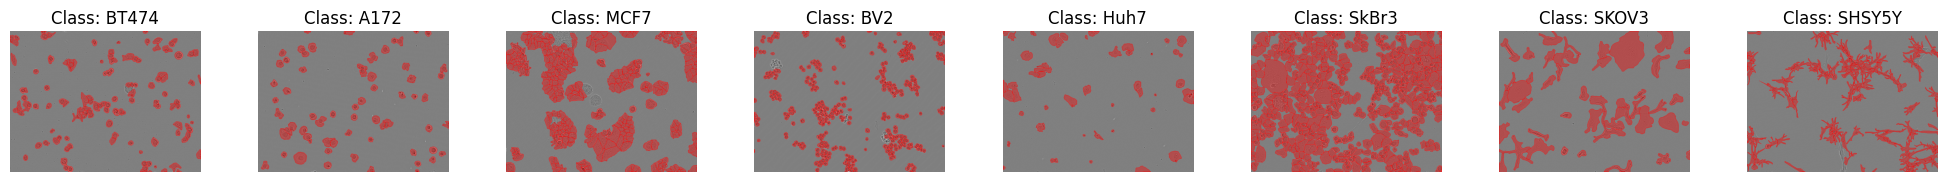

In [101]:
import os
import json
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


DATASET_DIR = 'dataset'
train_dir = os.path.join(DATASET_DIR, 'train')
val_dir = os.path.join(DATASET_DIR, 'val')
test_dir = os.path.join(DATASET_DIR, 'test')

train_json = os.path.join(DATASET_DIR, 'livecell_coco_train.json')
val_json = os.path.join(DATASET_DIR, 'livecell_coco_val.json')
test_json = os.path.join(DATASET_DIR, 'livecell_coco_test.json')


def load_json(json_file):
    with open(json_file, 'r') as f:
        return json.load(f)

train_annotations = load_json(train_json)
val_annotations = load_json(val_json)
test_annotations = load_json(test_json)


def get_image_file_name(annotations, image_id):
    images_info = annotations['images']
    for img_info in images_info:
        if img_info['id'] == image_id:
            return img_info['file_name']
    return None


def get_class_name_from_filename(image_file_name):
    if image_file_name:
        class_name = image_file_name.split('_')[0]
        return class_name
    return None


def visualize_one_image_per_class(annotations, data_dir):
    image_annotations = {}
    class_image_ids = {}


    for ann in annotations['annotations']:
        if ann['image_id'] not in image_annotations:
            image_annotations[ann['image_id']] = []
        image_annotations[ann['image_id']].append(ann)

    for img_info in annotations['images']:
        image_id = img_info['id']
        image_file_name = img_info['file_name']
        class_name = get_class_name_from_filename(image_file_name)
        
        if class_name and class_name not in class_image_ids:
            class_image_ids[class_name] = image_id


    num_samples = len(class_image_ids)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))
    fig.tight_layout()

    for i, (class_name, image_id) in enumerate(class_image_ids.items()):
        image_file_name = get_image_file_name(annotations, image_id)
        image_path = os.path.join(data_dir, image_file_name)
        image = Image.open(image_path).convert("RGBA")

        mask_image = Image.new("RGBA", image.size)
        mask_draw = ImageDraw.Draw(mask_image)

        annotations_for_image = image_annotations[image_id]

        for annotation in annotations_for_image:
            segmentations = annotation['segmentation']
            for segmentation in segmentations:
                if isinstance(segmentation, list):
                    # Convert flat list of points into [(x1, y1), (x2, y2), ...]
                    poly_points = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]
                    mask_draw.polygon(poly_points, outline="red", fill=(255, 0, 0, 100))

        # Blend the mask with the original image
        blended_image = Image.alpha_composite(image, mask_image)

        axes[i].imshow(blended_image)
        axes[i].axis('off')
        axes[i].set_title(f'Class: {class_name}')

    plt.show()

visualize_one_image_per_class(train_annotations, train_dir)


Here we can see one image for each class from train dataset with annotations. The annotations loaded well and they are corresponding to images.